In [53]:
%pip install pandas
%pip install pydmd
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install keras_tuner
%pip install keras
%pip install numpy

/bin/bash: /home/yurid/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.
/bin/bash: /home/yurid/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.
/bin/bash: /home/yurid/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.
/bin/bash: /home/yurid/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.
/bin/bash: /home/yurid/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.
/bin/bash: /home/yurid/miniconda3/envs/tf/lib/libtinfo.so.6: no version informat

In [54]:
import sys

base_path = '/home/yurid/git/tcc'
sys.path.insert(0, base_path)

In [55]:
from math import sqrt

import keras
import numpy as np
import pandas as pd
from keras import layers
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
from keras.layers import TimeDistributed



from src.filler import dmd_filler, interpolate_filler, fill_df
from src.dataframe import read_data, windowing, split_data, show_error_metrics
from src.scaler import Scaler
from src.model import train_model, hp_search
from src.model import hp_search, build_model

In [56]:
df_temp = pd.read_csv(
    f'{base_path}/data/daily_juiz de fora.csv',
    sep=',',
    parse_dates=['Timestamp'],
    index_col=['Timestamp'])

init_index = lambda _df: _df[_df.RADIATION != 0].index[0]

df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
    .resample('D') \
    .agg({'RADIATION': np.sum})

df = df.loc[df.index >= init_index(df)].replace(0, np.nan)
print(df.isna().sum())
df

RADIATION    34
dtype: int64


/tmp/ipykernel_56213/2528408258.py:9: FutureWarning: The provided callable <function sum at 0x7fb17c117790> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \


,RADIATION
Timestamp,
2007-05-26,9057.5
2007-05-27,10971.6
2007-05-28,13934.5
2007-05-29,10020.8
2007-05-30,7567.6
...,...
2022-12-27,16725.1
2022-12-28,15623.1
2022-12-29,10577.0


In [57]:
df = fill_df(df, interpolate_filler)
print(df.isna().sum())

RADIATION    0
dtype: int64


In [58]:
scaler = Scaler(df)
df_scaled = scaler.get_dataframe_scaled()
df_scaled

,RADIATION
2007-05-26,0.269568
2007-05-27,0.329010
2007-05-28,0.421021
2007-05-29,0.299483
2007-05-30,0.223300
...,...
2022-12-27,0.507681
2022-12-28,0.473459
2022-12-29,0.316755
2022-12-30,0.188572


In [59]:
X, Y = windowing(df_scaled, 3, 1)

In [60]:
for i in range(len(X)):
    print(X[i], Y[i])

[[0.26956819]
 [0.32900952]
 [0.42102076]] [0.29948294]
[[0.32900952]
 [0.42102076]
 [0.29948294]] [0.22330016]
[[0.42102076]
 [0.29948294]
 [0.22330016]] [0.22286229]
[[0.29948294]
 [0.22330016]
 [0.22286229]] [0.36858531]
[[0.22330016]
 [0.22286229]
 [0.36858531]] [0.30149217]
[[0.22286229]
 [0.36858531]
 [0.30149217]] [0.33582287]
[[0.36858531]
 [0.30149217]
 [0.33582287]] [0.54538143]
[[0.30149217]
 [0.33582287]
 [0.54538143]] [0.51460646]
[[0.33582287]
 [0.54538143]
 [0.51460646]] [0.41388755]
[[0.54538143]
 [0.51460646]
 [0.41388755]] [0.43227489]
[[0.51460646]
 [0.41388755]
 [0.43227489]] [0.48797416]
[[0.41388755]
 [0.43227489]
 [0.48797416]] [0.47227614]
[[0.43227489]
 [0.48797416]
 [0.47227614]] [0.51823673]
[[0.48797416]
 [0.47227614]
 [0.51823673]] [0.5240377]
[[0.47227614]
 [0.51823673]
 [0.5240377 ]] [0.52053476]
[[0.51823673]
 [0.5240377 ]
 [0.52053476]] [0.53009642]
[[0.5240377 ]
 [0.52053476]
 [0.53009642]] [0.51902862]
[[0.52053476]
 [0.53009642]
 [0.51902862]] [0.464

In [61]:
train_x, train_y, test_x, test_y = split_data(X, Y, length=len(df_scaled), ratio=0.9)

In [62]:
print(train_x.shape[1], train_x.shape[2])

3 1
(5129,)


Epoch 1/200
225/225 [==============================] - 4s 12ms/step - loss: 0.0304 - val_loss: 0.0237
Epoch 2/200
225/225 [==============================] - 2s 10ms/step - loss: 0.0266 - val_loss: 0.0241
Epoch 3/200
225/225 [==============================] - 2s 11ms/step - loss: 0.0264 - val_loss: 0.0240
Epoch 4/200
225/225 [==============================] - 2s 10ms/step - loss: 0.0258 - val_loss: 0.0232
Epoch 5/200
225/225 [==============================] - 2s 11ms/step - loss: 0.0258 - val_loss: 0.0235
Epoch 6/200
225/225 [==============================] - 2s 10ms/step - loss: 0.0262 - val_loss: 0.0232
Epoch 7/200
225/225 [==============================] - 2s 11ms/step - loss: 0.0257 - val_loss: 0.0244
Epoch 8/200
225/225 [==============================] - 2s 11ms/step - loss: 0.0260 - val_loss: 0.0236
Epoch 9/200
225/225 [==============================] - 2s 11ms/step - loss: 0.0257 - val_loss: 0.0235
Epoch 10/200
225/225 [==============================] - 2s 11ms/step - loss: 0.025

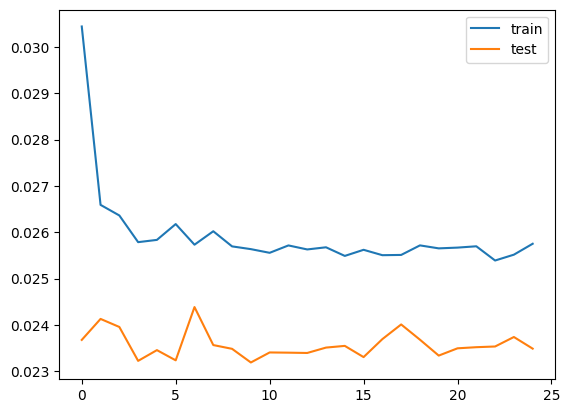

In [70]:
model = Sequential([
    LSTM(units=200, input_shape=(train_x.shape[1], train_x.shape[2])),
    Dense(1, activation='sigmoid')
])

model.compile(loss='mse', optimizer=keras.optimizers.legacy.Adam(learning_rate=0.01))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(train_x,
                     train_y,
                     epochs=200,
                     batch_size=16,
                     validation_split=0.3,
                     verbose=1,
                     callbacks=[es])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [73]:
predict = model.predict(test_x)
show_error_metrics(test_y.reshape(-1,1), predict)

18/18 [==============================] - 0s 7ms/step
Test R2: 0.293
Test MSE: 0.023
Test RMSE: 0.152
Test MAE: 0.120
Test MAPE: 0.363


Test R2: 0.293
Test MSE: 0.023
Test RMSE: 0.152
Test MAE: 0.120
Test MAPE: 0.363


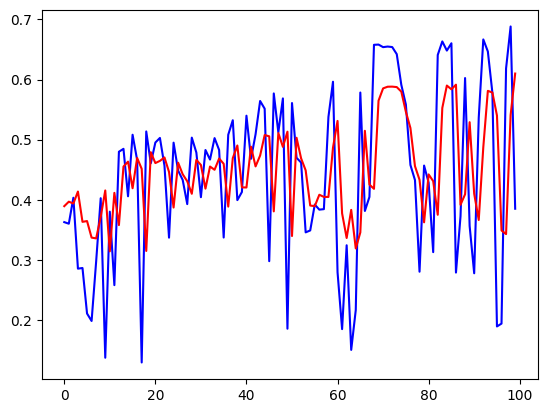

In [74]:
range_plot = 100

pyplot.plot(test_y.reshape(-1,1)[0:range_plot], color='blue', label='real')
pyplot.plot(predict[0:range_plot], color='red', label='incompleto')

show_error_metrics(test_y.reshape(-1,1), predict)

pyplot.show()